---
title: "A better understanding of PyMC objects using a linear regression example"
toc: true
toc_sticky: true
---

I previously [wrote](https://benslack19.github.io/prior-likelihood-posterior-predictive/) about my discovery of [Statistical Rethinking](https://xcelab.net/rm/statistical-rethinking/). The book's title could not be more spot-on--it's helped me look at statistics in a different way. This approach will set me up (hopefully) for learning new methods that will prove useful in my work.

I'm doing the problems with the Python package [PyMC3](https://docs.pymc.io/). Fortunately, a repo for the book's code using this package has already been created [here](https://github.com/pymc-devs/resources/tree/master/Rethinking_2). This repo gave me a starting point to write my own code and compare to the book's, which is written in R. I've also never used the PyMC3 package before so I took this as an opportunity to dive deep into some of the package's objects. The [PyMC3 documentation](https://docs.pymc.io/notebooks/api_quickstart.html) of course was also helpful.

In a series of posts, I will address a linear regression problem using PyMC3. Here I aim to get a better understanding of the `pymc` objects.

In [1]:
import arviz as az
import matplotlib.pyplot as plt
import numpy as np
import os
import pandas as pd
import pymc3 as pm
import scipy.stats as stats
import seaborn as sns

In [2]:
%load_ext nb_black
%config InlineBackend.figure_format = 'retina'
%load_ext watermark
RANDOM_SEED = 8927
np.random.seed(RANDOM_SEED)
az.style.use("arviz-darkgrid")

<IPython.core.display.Javascript object>

Of course, it's good to be cognizant of package versions so I am making that clear here.

In [3]:
%watermark -n -u -v -iv -w

Last updated: Wed May 05 2021

Python implementation: CPython
Python version       : 3.8.6
IPython version      : 7.20.0

matplotlib: 3.3.4
seaborn   : 0.11.1
numpy     : 1.20.1
pymc3     : 3.11.0
pandas    : 1.2.1
scipy     : 1.6.0
json      : 2.0.9
arviz     : 0.11.1

Watermark: 2.1.0



<IPython.core.display.Javascript object>

**Question**

Ths question come's from the [winter 2020, week 2 homework](https://github.com/rmcelreath/stat_rethinking_2020/blob/main/homework/week02/week02.pdf).

**The weights listed below were recorded in the !Kung census, but heights were not recorded for these individuals. Provide predicted heights and 89% compatibility intervals for each of these individuals. That is, fill in the table below, using model-based predictions.**

| Individual | weight | expected height | 89% interval |
| ------ | ------ | -------- | ---------- |
| 1|  45  |  |
| 2 | 40 |  |  |
| 3 | 65 | |  |
|4  | 31  |  |  |

Let's quickly take a look at the data to get a handle on what we're working with.

In [4]:
d = pd.read_csv("../data/a_input/Howell1.csv", sep=";", header=0)
d2 = d[d.age >= 18]  # filter to get only adults

d2.head()

,height,weight,age,male
0,151.765,47.825606,63.0,1
1,139.700,36.485807,63.0,0
2,136.525,31.864838,65.0,0
3,156.845,53.041914,41.0,1
4,145.415,41.276872,51.0,0


<IPython.core.display.Javascript object>

<AxesSubplot:xlabel='weight', ylabel='height'>

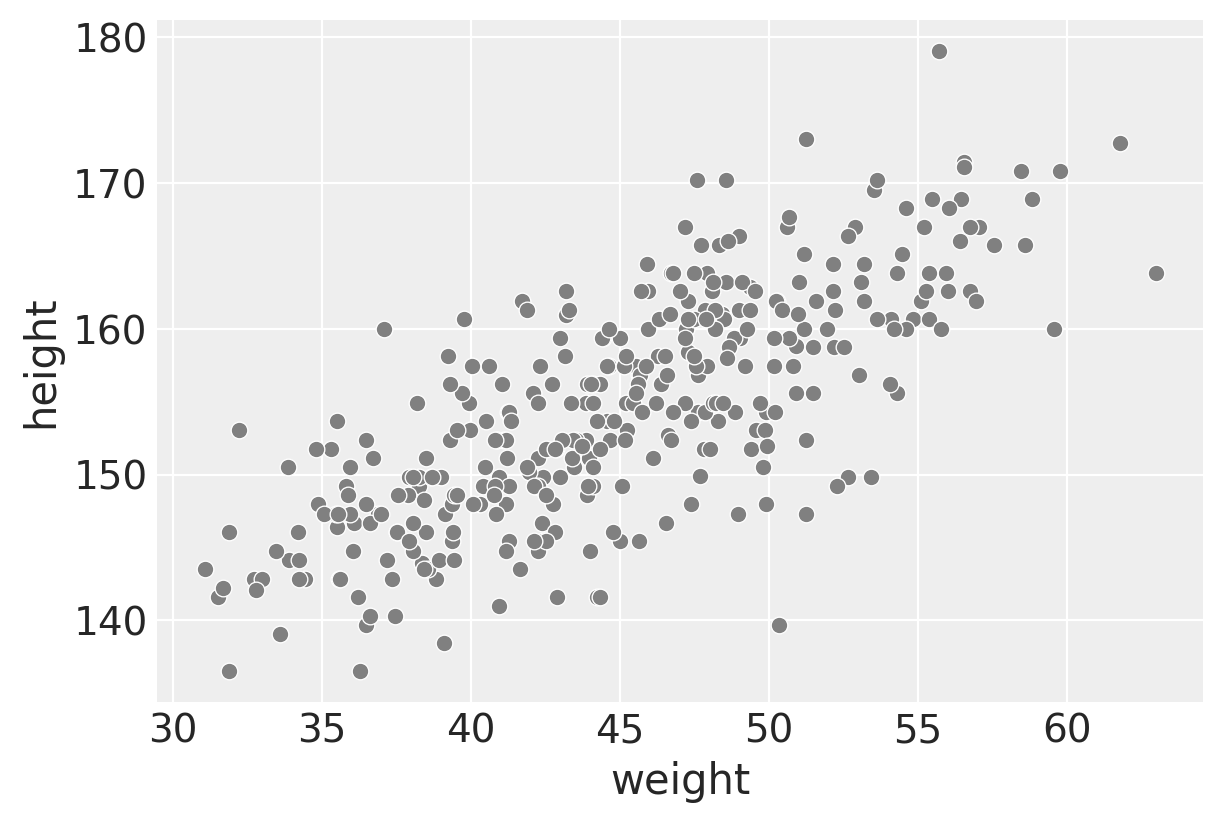

<IPython.core.display.Javascript object>

In [5]:
f, ax1 = plt.subplots(figsize=(6, 4))
sns.scatterplot(data=d2, x="weight", y="height", color="gray")

We'd expect a linear relationship between `weight` and `height` in the adult population and that's what we see here.

# Setting up the variables, producing `model ` and `trace` objects

First, I'll need to generate the posterior distribution from the entire dataset. I'll define the variables:

$\text{height}_i$ ~ Normal($\mu_i, \sigma$)
<br>
$\mu_i = \alpha + \beta(x_i  - \bar{x})$
<br>
$\alpha$ ~ $\text{Normal}(178, 20)$
<br>
$\beta$ ~ $\text{Log-Normal}(0, 1)$
<br>
$\sigma$ ~ $\text{Uniform}(0, 50)$

Important things to note about these variables.
- Whether the subscript *i* is there for a given variable matters. It will represent every row in the set of parameters returned by the function. We'll come back to this later.
- The tilde versus the equals sign matters. The former represents a stochastic relationship while the latter is deterministic.
- I used a prior for beta that will have a sensical relationship, such as being all positive. One way to accomplish this is to use lognormal.



In [6]:
# Get the average weight as part of the model definition
xbar = d2.weight.mean()

<IPython.core.display.Javascript object>

In [7]:
with pm.Model() as heights_model:

    # Priors are variables a, b, sigma
    # using pm.Normal is a way to represent the stochastic relationship the left has to right side of equation
    a = pm.Normal("a", mu=178, sd=20)
    b = pm.Lognormal("b", mu=0, sd=1)
    sigma = pm.Uniform("sigma", 0, 50)

    # This is a linear model (not really a prior or likelihood?)
    # Data included here (d2.weight, which is observed)
    # Mu is deterministic, but a and b are stochastic
    mu = a + b * (d2.weight - xbar)

    # Likelihood is height variable, which is also observed (data included here, d2.height))
    # Height is dependent on deterministic and stochastic variables
    height = pm.Normal("height", mu=mu, sd=sigma, observed=d2.height)

    # The next lines is doing the fitting and sampling all at once.
    # When I ran this without the return_inferencedata parameter set, I got a
    # warning and suggestion to set this explicitly. I wanted to see the difference.
    # Per the documentation: "With PyMC3 version >=3.9 the return_inferencedata=True
    # kwarg makes the sample function return an arviz.InferenceData object instead
    # of a MultiTrace. InferenceData has many advantages, compared to a MultiTrace.
    trace_m1 = pm.sample(1000, tune=1000, return_inferencedata=True)  #
    trace_m2 = pm.sample(1000, tune=1000, return_inferencedata=False)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [sigma, b, a]


Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 12 seconds.
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [sigma, b, a]


Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 12 seconds.


<IPython.core.display.Javascript object>

# Inspecting the `pymc3` objects

Before going through the rest of the exercise, it is helpful to dive deep and understand the objects in this call.

## Inspecting the `model` object

In [8]:
heights_model

<IPython.core.display.Javascript object>

It is comforting that this object is a simple reflection of the input.

Now let's take a look at the object's properties and methods, using the Python `dir` function. It returned a long list so let's limit using `filter` and a lambda function to those without the double underscore. (If you really want to understand what the attribues with underscores are, you can look [here](https://stackoverflow.com/questions/1301346/what-is-the-meaning-of-single-and-double-underscore-before-an-object-name).)

In [9]:
# But this is a way to limit the attributes to inspect
heights_model_methods2check = list(filter(lambda x: "__" not in x, dir(heights_model)))
heights_model_methods2check

['RV_dims',
 'Var',
 '_cache',
 '_config_context',
 '_context_class',
 '_parent',
 '_repr_latex_',
 '_str_repr',
 '_theano_config',
 'a',
 'add_coords',
 'add_random_variable',
 'b',
 'basic_RVs',
 'bijection',
 'check_bounds',
 'check_test_point',
 'cont_vars',
 'contexts',
 'coords',
 'd2logp',
 'd2logp_nojac',
 'datalogpt',
 'deterministics',
 'dict_to_array',
 'disc_vars',
 'dlogp',
 'dlogp_array',
 'dlogp_nojac',
 'fastd2logp',
 'fastd2logp_nojac',
 'fastdlogp',
 'fastdlogp_nojac',
 'fastfn',
 'fastlogp',
 'fastlogp_nojac',
 'flatten',
 'fn',
 'free_RVs',
 'height',
 'isroot',
 'logp',
 'logp_array',
 'logp_dlogp_function',
 'logp_elemwise',
 'logp_nojac',
 'logp_nojact',
 'logpt',
 'makefn',
 'missing_values',
 'model',
 'name',
 'name_for',
 'name_of',
 'named_vars',
 'ndim',
 'observed_RVs',
 'parent',
 'potentials',
 'prefix',
 'profile',
 'root',
 'shape_from_dims',
 'sigma',
 'test_point',
 'unobserved_RVs',
 'varlogpt',
 'vars']

<IPython.core.display.Javascript object>

It is still a pretty long list but we can poke around at a few of the attributes.

In [10]:
heights_model.basic_RVs

[a ~ Normal,
 b_log__ ~ TransformedDistribution,
 sigma_interval__ ~ TransformedDistribution,
 height ~ Normal]

<IPython.core.display.Javascript object>

In [11]:
heights_model.height

height ~ Normal

<IPython.core.display.Javascript object>

Most of the information related to our input. Let's look at the `trace` objects, which were a result of the `pm.sample` command.

## Inspecting the `trace` variables

The `trace` object contains the samples collected, in the order they were collected per the [getting started](https://docs.pymc.io/notebooks/getting_started.html) tutorial. This is an important object so I wanted to dive deeper into it.

Note that I used the variable name "trace" simply because the repo version produced a `MultiTrace` object, which is what happens when the `return_inferencedata` flag is not set. As you'll see, in the first example, it is probably not the best name, but I'll leave the names alone for now.

### `trace_m1` is a `arviz.InferenceData`

Let's start off by simply looking at the object.

In [12]:
type(trace_m1)

arviz.data.inference_data.InferenceData

<IPython.core.display.Javascript object>

In [13]:
trace_m1

Inference data with groups:
	> posterior
	> log_likelihood
	> sample_stats
	> observed_data

<IPython.core.display.Javascript object>

This was good to see, but I could go down a whole 'nother rabbit hole with just this object's attributes and functions. I'll leave it to [this Arviz page](https://arviz-devs.github.io/arviz/getting_started/XarrayforArviZ.html) to explain this object in more detail. I'll focus on the `trace_m2` object but here is a way to connect it with the posterior data from `trace_m1`.

In [14]:
trace_m1.posterior

<xarray.Dataset>
Dimensions:  (chain: 4, draw: 1000)
Coordinates:
  * chain    (chain) int64 0 1 2 3
  * draw     (draw) int64 0 1 2 3 4 5 6 7 8 ... 992 993 994 995 996 997 998 999
Data variables:
    a        (chain, draw) float64 154.0 154.0 155.1 154.1 ... 154.9 154.3 154.9
    b        (chain, draw) float64 0.8538 0.8616 0.9578 ... 0.866 0.9321 0.8399
    sigma    (chain, draw) float64 4.989 5.129 5.068 4.961 ... 5.09 5.019 5.242
Attributes:
    created_at:                 2021-05-05T14:18:00.979266
    arviz_version:              0.11.1
    inference_library:          pymc3
    inference_library_version:  3.11.0
    sampling_time:              11.833754777908325
    tuning_steps:               1000

<IPython.core.display.Javascript object>

### `trace_m2` is a `MultiTrace` object

The `MultiTrace` object that is outputted as a result of setting `return_inferencedata=False` in the `pm.sample()` call. (It's the same object that is outputted in the PyMC3 repo of the book's code which is why I decided to work with it here.) This is an important object so I wanted to dive deeper into it.

In [15]:
type(trace_m2)

pymc3.backends.base.MultiTrace

<IPython.core.display.Javascript object>

The trace object contains the samples collected, in the order they were collected per the PyMC3's. [getting started tutorial](https://docs.pymc.io/notebooks/getting_started.html).  It is much clearer to see this concretely when we use the `trace_to_dataframe` function.

In [16]:
trace_m2_df = pm.trace_to_dataframe(trace_m2)
trace_m2_df

,a,b,sigma
0,154.589194,0.889071,4.885394
1,154.589194,0.889071,4.885394
2,154.818923,0.838186,5.271951
3,154.920790,0.987778,5.107954
4,154.920790,0.987778,5.107954
...,...,...,...
3995,154.393120,0.915738,5.082579
3996,155.231970,0.894059,5.201840
3997,154.932506,0.905143,5.038751
3998,154.841507,0.881522,5.391670


<IPython.core.display.Javascript object>

Why are there 4000 rows? It can be explained by looking at some of the earlier code and the output.

This was in the initial model fitting:
<br>
`trace_m = pm.sample(1000, tune=1000)`
<br>
`Multiprocess sampling (4 chains in 4 jobs)`

I don't know how to take into account this multiprocess sampling, so I'll treat the 4000 rows as simply being different samples drawn from the posterior distribution. More explanation is shown [here](https://stackoverflow.com/questions/61969968/understanding-the-parameters-of-pymc3-package).

As you can see, each row is a different instantiation of alpha, beta, and sigma values. Each row is a different "*i*th" set of values that is in these equations.

$\text{height}_i$ ~ Normal($\mu_i, \sigma$)
<br>
$\mu_i = \alpha + \beta(x_i  - \bar{x})$

We'll come back to this. We can also check out the object attributes.

In [17]:
trace_m2_methods2check = list(filter(lambda x: "__" not in x, dir(trace_m2)))
trace_m2_methods2check

['_attrs',
 '_report',
 '_slice',
 '_straces',
 'add_values',
 'chains',
 'get_sampler_stats',
 'get_values',
 'nchains',
 'point',
 'points',
 'remove_values',
 'report',
 'stat_names',
 'varnames']

<IPython.core.display.Javascript object>

Let's inspect some of the object methods.

In [18]:
# Trace object's variable names
trace_m2.varnames

['a', 'b_log__', 'sigma_interval__', 'b', 'sigma']

<IPython.core.display.Javascript object>

In [19]:
# Inspect samples, which are parameters
print("a samples: ", trace_m2["a"][0:5])
print("b samples: ", trace_m2["b"][0:5])
print("sigma samples: ", trace_m2["sigma"][0:5])
# print("mu samples: ", trace_m["mu"][0:5])
# print("height samples: ", trace_m["height"][0:5])

print("mu and height are deterministic or dependent on deterministic variables")

a samples:  [154.58919424 154.58919424 154.81892314 154.92078981 154.92078981]
b samples:  [0.88907119 0.88907119 0.83818599 0.9877783  0.9877783 ]
sigma samples:  [4.88539414 4.88539414 5.27195133 5.10795395 5.10795395]
mu and height are deterministic or dependent on deterministic variables


<IPython.core.display.Javascript object>

In [20]:
# Another way to inspect
trace_m2.get_values("a")[0:5]

array([154.58919424, 154.58919424, 154.81892314, 154.92078981,
       154.92078981])

<IPython.core.display.Javascript object>

A chain is a single run of Markov Chain Monte Carlo. I haven't learned MCMC yet, but chains in `pymc3` are explained [here](https://stackoverflow.com/questions/49825216/what-is-a-chain-in-pymc3).

In [21]:
trace_m2.chains

[0, 1, 2, 3]

<IPython.core.display.Javascript object>

## Code explanation

With regards to the sampling in the code above. This is taken from the PyMC example notebook.

> We could use a quadratic approximation like McElreath does in his book and we did in code 2.6. But Using PyMC3 is really simple to just sample from the model using a "sampler method". Most common sampler methods are members of the Markov Chain Monte Carlo Method (MCMC) family (for details read Section 2.4.3 and Chapter 8 of Statistical Rethinking).

> PyMC3 comes with various samplers. Some samplers are more suited than others for certain type of variable (and/or problems). For now we are going to let PyMC3 choose the sampler for us. PyMC3 also tries to provide a reasonable starting point for the simulation. By default PyMC3 uses the same adaptive procedure as in STAN `'jitter+adapt_diag'`, which starts with a identity mass matrix and then adapts a diagonal based on the variance of the tuning samples.

> You can read more details of PyMC3 [here](https://docs.pymc.io/notebooks/getting_started.html).

This is taken from the link which helps explain the code.

> **Gradient-based sampling methods**

> PyMC3 has the standard sampling algorithms like adaptive Metropolis-Hastings and adaptive slice sampling, but PyMC3’s most capable step method is the No-U-Turn Sampler. NUTS is especially useful on models that have many continuous parameters, a situation where other MCMC algorithms work very slowly. It takes advantage of information about where regions of higher probability are, based on the gradient of the log posterior-density. This helps it achieve dramatically faster convergence on large problems than traditional sampling methods achieve. PyMC3 relies on Theano to analytically compute model gradients via automatic differentiation of the posterior density. NUTS also has several self-tuning strategies for adaptively setting the tunable parameters of Hamiltonian Monte Carlo. For random variables that are undifferentiable (namely, discrete variables) NUTS cannot be used, but it may still be used on the differentiable variables in a model that contains undifferentiable variables.

> NUTS requires a scaling matrix parameter, which is analogous to the variance parameter for the jump proposal distribution in Metropolis-Hastings, although NUTS uses it somewhat differently. The matrix gives the rough shape of the distribution so that NUTS does not make jumps that are too large in some directions and too small in other directions. It is important to set this scaling parameter to a reasonable value to facilitate efficient sampling. This is especially true for models that have many unobserved stochastic random variables or models with highly non-normal posterior distributions. Poor scaling parameters will slow down NUTS significantly, sometimes almost stopping it completely. A reasonable starting point for sampling can also be important for efficient sampling, but not as often.

> PyMC3 automatically initializes NUTS to reasonable values based on the variance of the samples obtained during a tuning phase. A little bit of noise is added to ensure different, parallel, chains start from different points. Also, PyMC3 will automatically assign an appropriate sampler if we don’t supply it via the step keyword argument...

# Summary

In this post, I wanted to get my feet wet with using `pymc`. The main objects are created with the model definition (the code block starting with `with pm.Model() as heights_model` in this case). We see that we can get the posterior distribution in our `trace_m1` and `trace_m2` objects, the difference here is what we get back using the `return_inferencedata` flag. In the next post, we'll look closer at the posterior distribution and interpret it.